# 数据理解和清洗

步骤1：导入数据并初步查看
首先导入数据并查看数据的基本信息，如列名、数据类型和前几行数据。
检查数据是否包含明显的异常值或错误值。

In [1]:
# 导入所需的库
import pandas as pd
import numpy as np

# 读取数据
file_path = './当当网畅销图书榜单数据.csv'  # 请确认文件路径是否正确
data = pd.read_csv(file_path)

# 查看数据的基本信息
print("数据的基本信息：")
print(data.info())

# 查看前几行数据
print("\n前几行数据：")
data.head()

数据的基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   书名      2000 non-null   object 
 1   作者      1997 non-null   object 
 2   出版日期    1999 non-null   object 
 3   出版社     2000 non-null   object 
 4   原价      2000 non-null   float64
 5   售价      2000 non-null   float64
 6   折扣比例    2000 non-null   object 
 7   排序      2000 non-null   int64  
 8   排行榜类型   2000 non-null   object 
 9   推荐值     2000 non-null   object 
 10  电子书价格   693 non-null    float64
 11  评论数     1996 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 187.6+ KB
None

前几行数据：


,书名,作者,出版日期,出版社,原价,售价,折扣比例,排序,排行榜类型,推荐值,电子书价格,评论数
0,你当像鸟飞往你的山（中文版销量超200万册，比尔・盖茨年度特别推,塔拉,2019-11-01,南海出版公司,59.0,35.4,6.0折,1,2020年,100%,24.99,1701192.0
1,人间失格（日本小说家太宰治代表作，一个对村上春树影响至深的绝,太宰治,2015-08-01,作家出版社,25.0,9.8,3.9折,2,2020年,99.8%,4.99,2227071.0
2,乌合之众 : 大众心理研究（群体心理学创始人古斯塔夫・勒庞代表作,古斯塔夫・勒庞,2018-04-06,民主与建设出版社,26.0,10.1,3.9折,3,2020年,100%,NaN,752052.0
3,神奇校车・图画书版（全12册）,乔安娜柯尔,2018-05-10,贵州人民出版社,198.0,99.0,5.0折,4,2020年,99.9%,NaN,1783796.0
4,作家榜名著：月亮与六便士（158万+读者高分推荐版！连续8年高居畅,毛姆,2017-01-10,浙江文艺出版社,39.8,16.9,4.2折,5,2020年,100%,3.99,1587510.0


步骤2：数据完整性检查
空值检查：检查数据集中是否存在缺失值。如果有缺失值，需要根据情况进行填充或删除。
重复值检查：检查是否有完全重复的行，并删除这些重复的数据。

In [2]:
# 步骤2：数据完整性检查
# 检查空值
print("\n每列空值数量：")
print(data.isnull().sum())

# 删除包含空值的行或根据情况填充空值
# data = data.dropna() # 如果选择删除空值行
# 或者进行填充，如 data['评论数'].fillna(0, inplace=True)

# 检查重复值
print("\n重复值数量：", data.duplicated().sum())
data = data.drop_duplicates()  # 删除重复的行


每列空值数量：
书名          0
作者          3
出版日期        1
出版社         0
原价          0
售价          0
折扣比例        0
排序          0
排行榜类型       0
推荐值         0
电子书价格    1307
评论数         4
dtype: int64

重复值数量： 0


步骤3：数据格式修正
将价格、折扣等字段转换为数值类型，并统一格式（如将折扣比例转换为小数）。
统一日期格式，确保出版日期字段的格式一致。

In [3]:
# 处理折扣比例（如“5折”转换为0.5）
def convert_discount(discount):
    if pd.isna(discount):
        return np.nan
    try:
        # 去除空格，转换折扣格式
        cleaned_discount = discount.strip().replace('折', '').replace('%', '')
        return float(cleaned_discount) / 10
    except:
        return np.nan

# 应用转换函数
data['折扣比例'] = data['折扣比例'].apply(convert_discount)

# 检查转换后的数据
print("\n转换后的数据格式：")
data[['原价', '售价', '电子书价格', '折扣比例']].head(10)


转换后的数据格式：


,原价,售价,电子书价格,折扣比例
0,59.0,35.4,24.99,0.60
1,25.0,9.8,4.99,0.39
2,26.0,10.1,NaN,0.39
3,198.0,99.0,NaN,0.50
4,39.8,16.9,3.99,0.42
5,55.0,34.5,21.99,0.63
6,38.0,19.0,17.10,0.50
7,42.0,23.1,29.99,0.55
8,35.0,17.5,NaN,0.50
9,39.6,19.8,39.60,0.50


通过机器学习算法，根据其他相关特征（如原价、折扣比例、评论数等）预测电子书价格并填充。

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 假设数据已加载为 data
# 从原始数据集中提取特征和目标变量
features = data[['原价', '折扣比例', '评论数']].copy()  # 确保 features 变量存在
target = data['电子书价格'].copy()  # 确保 target 变量存在

# 将 features 和 target 合并为一个数据框
combined_data = pd.concat([features, target], axis=1)
combined_data.dropna(inplace=True)  # 删除任何缺失值的行

# 分离 features 和 target
features_cleaned = combined_data.iloc[:, :-1]
target_cleaned = combined_data.iloc[:, -1]

# 现在再次检查 features_cleaned 和 target_cleaned 的长度是否一致
print("Features和Target的长度：", len(features_cleaned), len(target_cleaned))

# 训练预测模型
X_train, X_test, y_train, y_test = train_test_split(features_cleaned, target_cleaned, test_size=0.2, random_state=0)

# 创建并训练随机森林模型
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# 预测电子书价格的空值部分
unknown_features = data[data['电子书价格'].isnull()][['原价', '折扣比例', '评论数']].fillna(0)
predicted_prices = model.predict(unknown_features)

# 将预测值填充到原始数据中
data.loc[data['电子书价格'].isnull(), '电子书价格'] = predicted_prices

# 检查电子书价格空值是否已填充完毕
print("填充后的电子书价格空值数量：", data['电子书价格'].isnull().sum())

Features和Target的长度： 693 693
填充后的电子书价格空值数量： 0


In [5]:
# 将电子书价格保留一位小数
data['电子书价格'] = data['电子书价格'].round(1)

# 检查结果
data.head()

,书名,作者,出版日期,出版社,原价,售价,折扣比例,排序,排行榜类型,推荐值,电子书价格,评论数
0,你当像鸟飞往你的山（中文版销量超200万册，比尔・盖茨年度特别推,塔拉,2019-11-01,南海出版公司,59.0,35.4,0.60,1,2020年,100%,25.0,1701192.0
1,人间失格（日本小说家太宰治代表作，一个对村上春树影响至深的绝,太宰治,2015-08-01,作家出版社,25.0,9.8,0.39,2,2020年,99.8%,5.0,2227071.0
2,乌合之众 : 大众心理研究（群体心理学创始人古斯塔夫・勒庞代表作,古斯塔夫・勒庞,2018-04-06,民主与建设出版社,26.0,10.1,0.39,3,2020年,100%,3.9,752052.0
3,神奇校车・图画书版（全12册）,乔安娜柯尔,2018-05-10,贵州人民出版社,198.0,99.0,0.50,4,2020年,99.9%,60.9,1783796.0
4,作家榜名著：月亮与六便士（158万+读者高分推荐版！连续8年高居畅,毛姆,2017-01-10,浙江文艺出版社,39.8,16.9,0.42,5,2020年,100%,4.0,1587510.0


步骤4：异常值处理
检查数值字段（如价格、评论数）的分布情况，找出可能的异常值。
对于检测到的异常值，可以根据业务规则进行处理（如设定合理的上下限）。

In [6]:
# 步骤4：异常值处理
# 描述性统计查看可能的异常值
print("\n数据的描述性统计：")
print(data.describe())

# 处理异常值，如限制评论数和售价的范围
# 假设评论数应在0到100000之间，售价应在0到2000之间
data = data[(data['评论数'].between(0, 100000)) & (data['售价'].between(0, 2000))]

# 检查处理后的数据
print("\n处理后的数据描述性统计：")
print(data.describe())

# 保存清洗后的数据
cleaned_file_path = './当当网畅销图书榜单数据_cleaned.csv'
data.to_csv(cleaned_file_path, index=False)
print(f"\n清洗后的数据已保存到 {cleaned_file_path}")


数据的描述性统计：
                原价           售价         折扣比例           排序        电子书价格  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean     61.707300    32.415550     0.525690   250.500000    28.112250   
std      66.719261    34.713208     0.131553   144.373376    38.562774   
min      14.800000     2.100000     0.080000     1.000000     0.000000   
25%      29.900000    14.775000     0.450000   125.750000     6.800000   
50%      45.000000    24.000000     0.500000   250.500000    22.500000   
75%      64.000000    35.800000     0.600000   375.250000    36.000000   
max     828.000000   455.400000     0.990000   500.000000   405.000000   

                评论数  
count  1.996000e+03  
mean   3.771247e+05  
std    4.221029e+05  
min    4.900000e+01  
25%    1.283530e+05  
50%    2.395670e+05  
75%    4.268780e+05  
max    3.427401e+06  

处理后的数据描述性统计：
               原价          售价        折扣比例          排序       电子书价格  \
count  343.000000  343.000000  343.000000

# 探索性数据分析 (EDA)

步骤1：基础统计分析
计算关键数值指标的统计量（均值、中位数、标准差、最小值和最大值），包括评论数、售价、折扣比例等，以便了解数据的总体情况。

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置可视化风格
sns.set(style="whitegrid")

# 步骤1：基础统计分析
print("基础统计分析：")
print(data[['评论数', '售价', '折扣比例']].describe())

# 计算均值、中位数和标准差
mean_values = data[['评论数', '售价', '折扣比例']].mean()
median_values = data[['评论数', '售价', '折扣比例']].median()
std_dev_values = data[['评论数', '售价', '折扣比例']].std()

print("\n均值：\n", mean_values)
print("\n中位数：\n", median_values)
print("\n标准差：\n", std_dev_values)

基础统计分析：
                评论数          售价        折扣比例
count    343.000000  343.000000  343.000000
mean   67157.204082   33.902157    0.505627
std    21085.283122   40.187058    0.150357
min       49.000000    2.500000    0.090000
25%    52170.500000   15.150000    0.420000
50%    69107.000000   24.900000    0.500000
75%    84468.000000   36.925000    0.550000
max    99817.000000  349.000000    0.990000

均值：
 评论数     67157.204082
售价         33.902157
折扣比例        0.505627
dtype: float64

中位数：
 评论数     69107.0
售价         24.9
折扣比例        0.5
dtype: float64

标准差：
 评论数     21085.283122
售价         40.187058
折扣比例        0.150357
dtype: float64


步骤2：数据分布分析
检查关键数值指标的分布情况，通过绘制直方图或箱线图，查看数据的集中趋势和离散程度，识别异常值或数据的偏态。

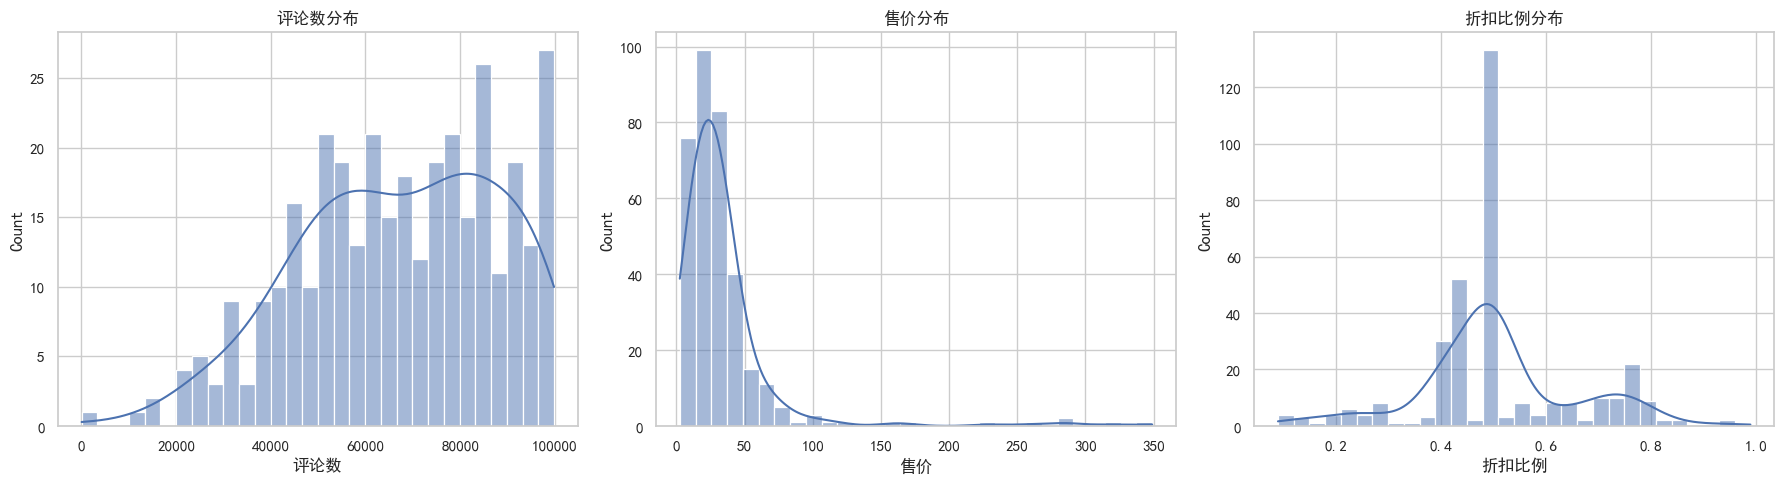

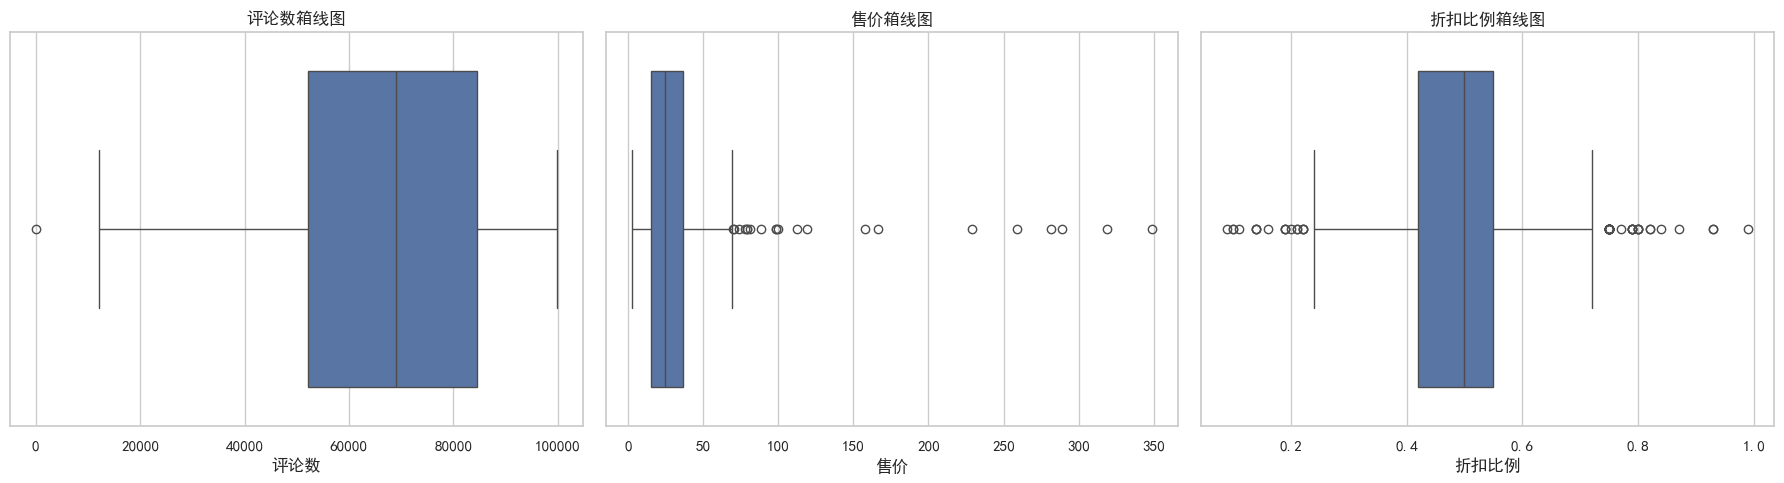

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

# 设置中文字体路径
font_path = 'C:/Windows/Fonts/simhei.ttf'  # 确保文件路径正确
prop = font_manager.FontProperties(fname=font_path)

# 设置全局字体为中文字体
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 步骤2：数据分布分析
# 评论数、售价和折扣比例的直方图
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(data['评论数'], bins=30, kde=True)
plt.title('评论数分布', fontproperties=prop)

plt.subplot(1, 3, 2)
sns.histplot(data['售价'], bins=30, kde=True)
plt.title('售价分布', fontproperties=prop)

plt.subplot(1, 3, 3)
sns.histplot(data['折扣比例'], bins=30, kde=True)
plt.title('折扣比例分布', fontproperties=prop)

plt.tight_layout()
plt.show()

# 绘制箱线图检查是否存在异常值
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x=data['评论数'])
plt.title('评论数箱线图', fontproperties=prop)

plt.subplot(1, 3, 2)
sns.boxplot(x=data['售价'])
plt.title('售价箱线图', fontproperties=prop)

plt.subplot(1, 3, 3)
sns.boxplot(x=data['折扣比例'])
plt.title('折扣比例箱线图', fontproperties=prop)

plt.tight_layout()
plt.show()


步骤3：时间趋势分析
对出版日期进行分析，观察图书的出版趋势。
分析各年度的畅销图书数量，找出是否存在显著的时间规律。

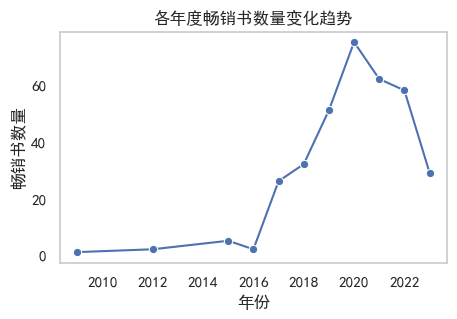

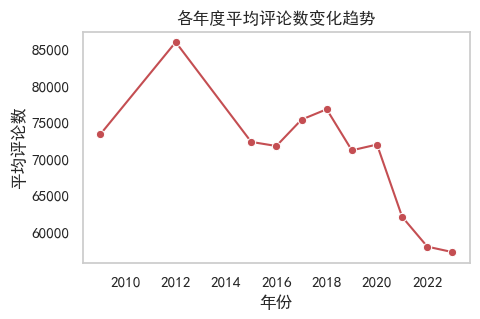

In [9]:
# 确保 '出版日期' 列是 datetime 类型
data['出版日期'] = pd.to_datetime(data['出版日期'], errors='coerce')

# 将出版日期转换为年份
data['出版年份'] = data['出版日期'].dt.year

# 统计每年的畅销书数量
yearly_books = data['出版年份'].value_counts().sort_index()

plt.figure(figsize=(5, 3))
sns.lineplot(x=yearly_books.index, y=yearly_books.values, marker='o')
plt.title('各年度畅销书数量变化趋势')
plt.xlabel('年份')
plt.ylabel('畅销书数量')
plt.grid()
plt.show()

# 分析各年份畅销书的平均评论数
yearly_avg_comments = data.groupby('出版年份')['评论数'].mean()

plt.figure(figsize=(5, 3))
sns.lineplot(x=yearly_avg_comments.index, y=yearly_avg_comments.values, marker='o', color='r')
plt.title('各年度平均评论数变化趋势')
plt.xlabel('年份')
plt.ylabel('平均评论数')
plt.grid()
plt.show()


# 数据可视化

1. 热销书籍和作者分布
目标：展示畅销书籍和高频作者的分布。
方法：
条形图：展示最畅销的书籍排名。
词云：展示出现频率较高的作者。

C:\Users\97059\AppData\Local\Temp\ipykernel_23216\1490758746.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_books.values, y=top_books.index, palette='viridis')
D:\anaconda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


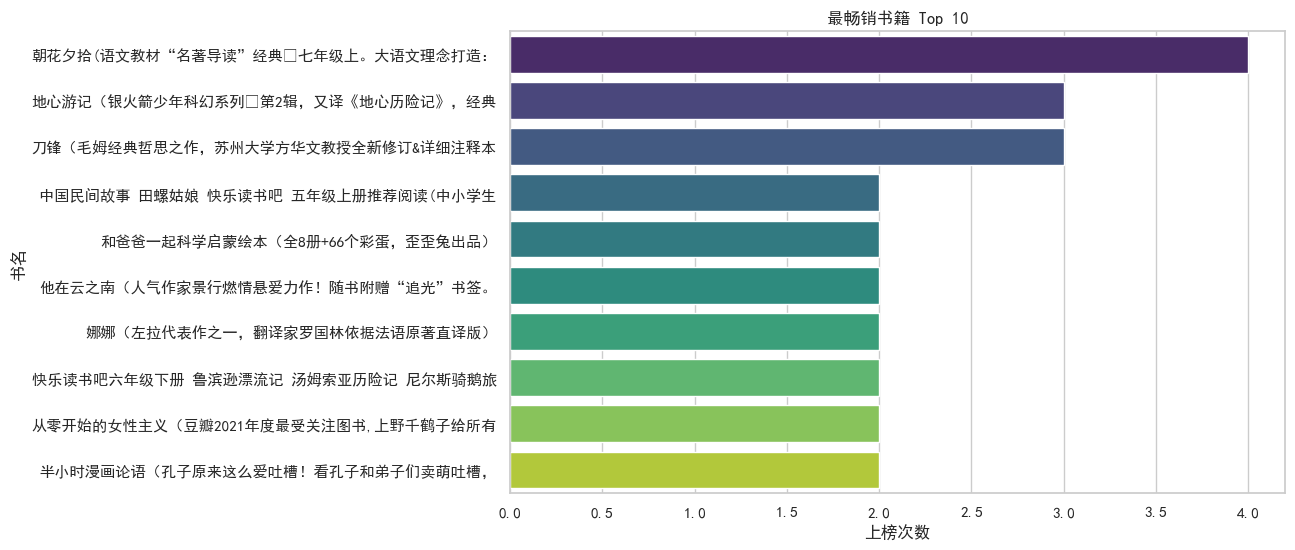

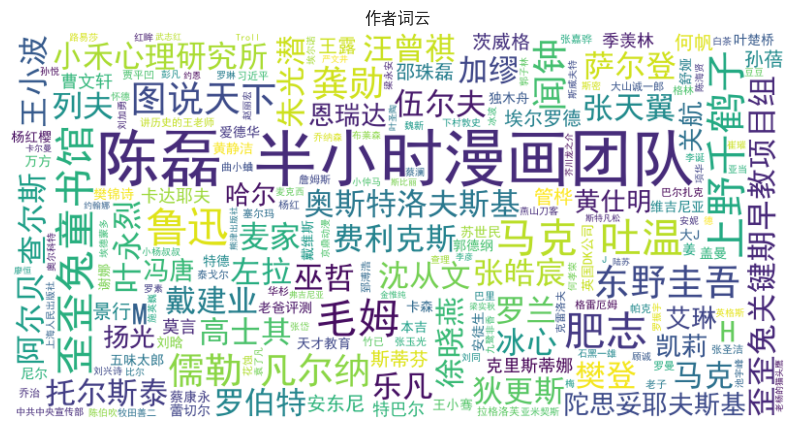

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 显示中文字体
plt.rcParams['font.sans-serif'] = ['AlibabaPuHuiTi-2-55-Regular']  # 使用阿里巴巴普惠体显示中文
plt.rcParams['axes.unicode_minus'] = False  # 解决坐标轴负号显示问题

# 热销书籍的分布（条形图）
top_books = data['书名'].value_counts().head(10)  # 统计出现次数最多的前10本书
plt.figure(figsize=(10, 6))
sns.barplot(x=top_books.values, y=top_books.index, palette='viridis')
plt.title('最畅销书籍 Top 10')
plt.xlabel('上榜次数')
plt.ylabel('书名')
plt.show()

# 作者分布（词云）
author_text = ' '.join(data['作者'].dropna())  # 将作者字段连接成一个字符串

wordcloud = WordCloud(font_path='C:/Windows/Fonts/simhei.ttf', background_color='white', width=800, height=400).generate(author_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 不显示坐标轴
plt.title('作者词云')
plt.show()

2. 价格和销量的关系
目标：分析售价、原价和评论数之间的关系，研究价格与销量的关联性。
方法：
散点图：展示售价与评论数的关系，并通过颜色或大小展示折扣对销量的影响。

D:\anaconda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 165 (\N{YEN SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


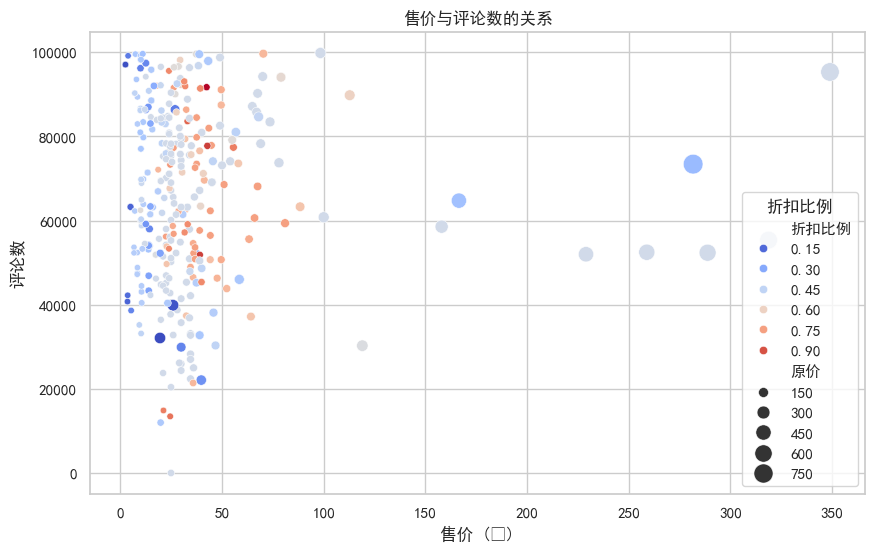

In [11]:
# 价格和销量的关系（散点图）
plt.figure(figsize=(10, 6))
sns.scatterplot(x='售价', y='评论数', hue='折扣比例', size='原价', sizes=(20, 200), data=data, palette='coolwarm', legend='brief')
plt.title('售价与评论数的关系')
plt.xlabel('售价 (¥)')
plt.ylabel('评论数')
plt.legend(title='折扣比例')
plt.show()

3. 折扣分析
目标：分析折扣比例的分布，找出常见的折扣范围，并分析折扣与图书受欢迎程度（如评论数）的关系。
方法：
折扣比例的分布图：展示所有图书的折扣比例分布情况。
折扣与评论数的关系图：通过箱线图或小提琴图分析不同折扣下的评论数分布。

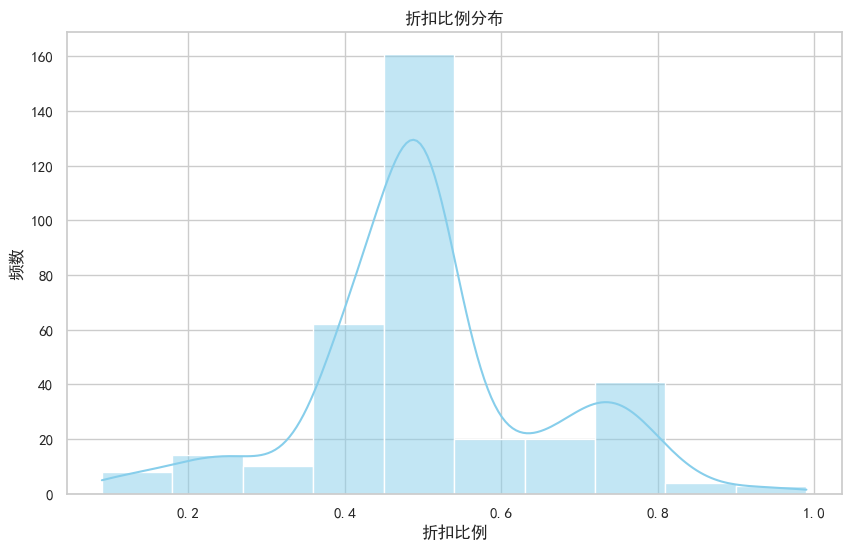

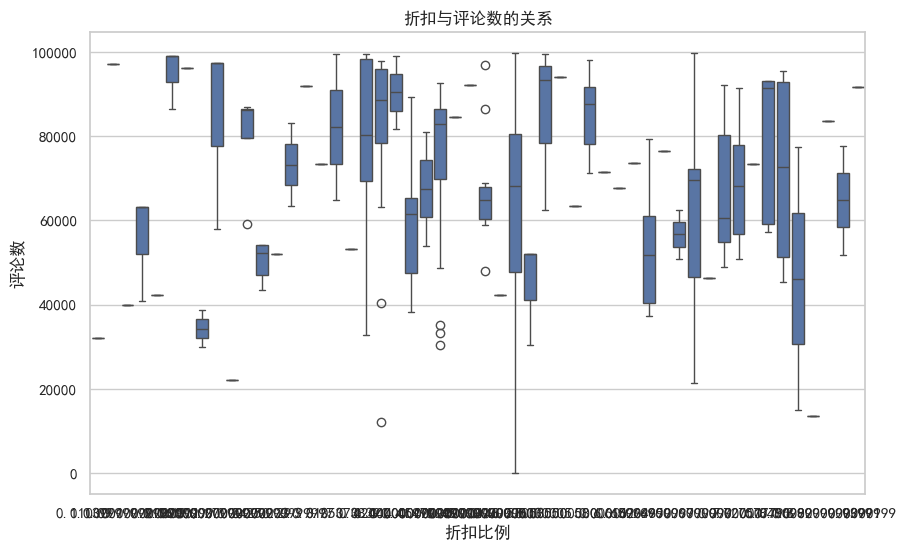

In [12]:
# 折扣比例的分布（直方图）
plt.figure(figsize=(10, 6))
sns.histplot(data['折扣比例'].dropna(), bins=10, kde=True, color='skyblue')
plt.title('折扣比例分布')
plt.xlabel('折扣比例')
plt.ylabel('频数')
plt.show()

# 折扣与评论数的关系（箱线图）
plt.figure(figsize=(10, 6))
sns.boxplot(x='折扣比例', y='评论数', data=data)
plt.title('折扣与评论数的关系')
plt.xlabel('折扣比例')
plt.ylabel('评论数')
plt.show()

# 深入分析

1. 作者影响力分析
目标：通过计算每位作者的平均推荐值、评论数和上榜图书数量，评估作者的影响力。
方法：
计算每个作者的上榜次数。
计算每个作者的平均推荐值和平均评论数。

作者影响力分析 - 前10名作者：
             作者  上榜图书数量    平均推荐值         平均评论数
241  陈磊・半小时漫画团队      10  1.00000  61046.400000
194          肥志       4  0.99925  53057.500000
150          毛姆       4  0.99925  81195.250000
147      歪歪兔童书馆       4  1.00000  57454.750000
250       马克・吐温       4  1.00000  88415.500000
254          鲁迅       4  1.00000  98224.000000
8         上野千鹤子       4  1.00000  75761.750000
10         东野圭吾       3  1.00000  63790.666667
32       儒勒・凡尔纳       3  1.00000  61492.000000
259          龚勋       3  1.00000  65125.333333


C:\Users\97059\AppData\Local\Temp\ipykernel_23216\3719282366.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='上榜图书数量', y='作者', data=top_authors, palette='coolwarm')
D:\anaconda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


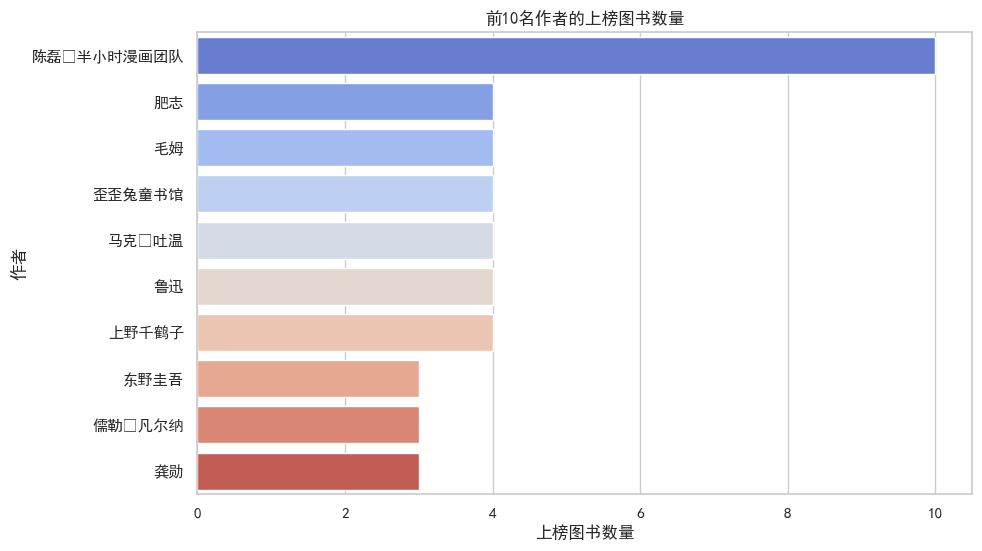

In [18]:
import pandas as pd

# 假设data是你的数据集
# 处理推荐值列，去掉%符号并转换为浮点数
def clean_recommend_value(val):
    try:
        if isinstance(val, str) and '%' in val:
            return float(val.replace('%', '')) / 100  # 将"100%" 转换为 1.0
        return float(val)
    except ValueError:
        return None

data['推荐值'] = data['推荐值'].apply(clean_recommend_value)

# 确保评论数列也是数值类型（如有必要）
data['评论数'] = pd.to_numeric(data['评论数'], errors='coerce')

# 计算每个作者的上榜次数、平均推荐值和平均评论数
author_rank = data.groupby('作者').agg(
    上榜图书数量=('书名', 'count'),
    平均推荐值=('推荐值', 'mean'),
    平均评论数=('评论数', 'mean')
).reset_index()

# 按上榜图书数量排序，显示影响力较大的作者
top_authors = author_rank.sort_values(by='上榜图书数量', ascending=False).head(10)

print("作者影响力分析 - 前10名作者：")
print(top_authors)

# 可视化作者影响力
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='上榜图书数量', y='作者', data=top_authors, palette='coolwarm')
plt.title('前10名作者的上榜图书数量')
plt.xlabel('上榜图书数量')
plt.ylabel('作者')
plt.show()


2. 价格分析
目标：研究不同价位区间的畅销书特征，分析不同价位图书的销量和推荐值。
方法：
将售价划分为不同的区间（例如低价位、中等价位、高价位）。
分析各个价位区间的平均推荐值和评论数。

价格分析：
       售价区间     平均推荐值         平均评论数  上榜图书数量
0     0-50元  0.999664  66615.233553     304
1   51-100元  0.999759  74468.379310      29
2  101-150元  1.000000  60033.000000       2
3  151-200元  1.000000  61649.000000       2
4  201-300元  0.999000  57567.250000       4
5  301-500元  1.000000  75337.000000       2


C:\Users\97059\AppData\Local\Temp\ipykernel_23216\3834524345.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_analysis = data.groupby('售价区间').agg(
C:\Users\97059\AppData\Local\Temp\ipykernel_23216\3834524345.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='售价区间', y='上榜图书数量', data=price_analysis, palette='coolwarm')


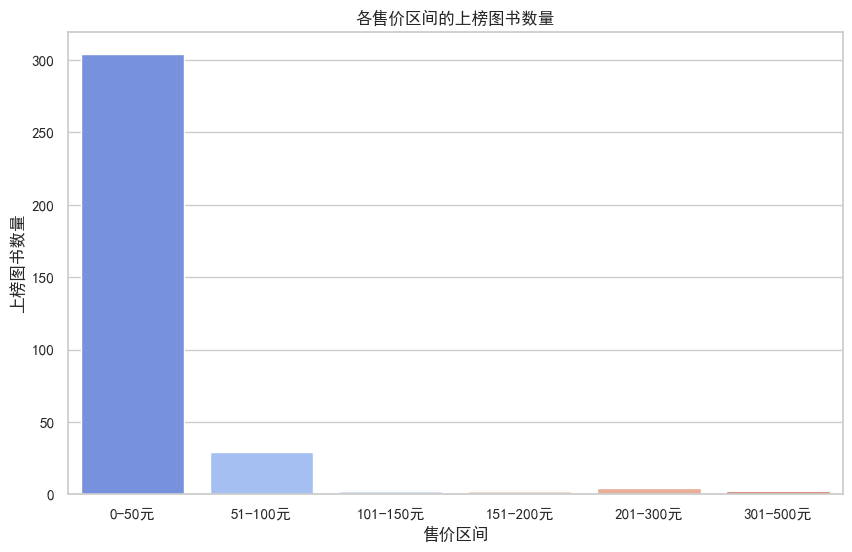

C:\Users\97059\AppData\Local\Temp\ipykernel_23216\3834524345.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='售价区间', y='平均评论数', data=price_analysis, palette='viridis')


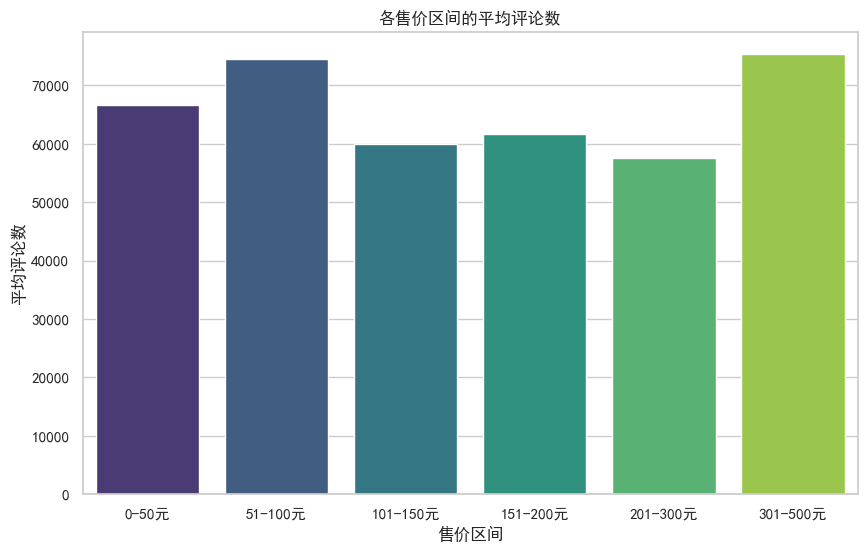

In [14]:
# 定义售价区间
bins = [0, 50, 100, 150, 200, 300, 500]
labels = ['0-50元', '51-100元', '101-150元', '151-200元', '201-300元', '301-500元']
data['售价区间'] = pd.cut(data['售价'], bins=bins, labels=labels)

# 计算各售价区间的平均推荐值和评论数
price_analysis = data.groupby('售价区间').agg(
    平均推荐值=('推荐值', 'mean'),
    平均评论数=('评论数', 'mean'),
    上榜图书数量=('书名', 'count')
).reset_index()

print("价格分析：")
print(price_analysis)

# 可视化售价区间的上榜图书数量和平均评论数
plt.figure(figsize=(10, 6))
sns.barplot(x='售价区间', y='上榜图书数量', data=price_analysis, palette='coolwarm')
plt.title('各售价区间的上榜图书数量')
plt.xlabel('售价区间')
plt.ylabel('上榜图书数量')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='售价区间', y='平均评论数', data=price_analysis, palette='viridis')
plt.title('各售价区间的平均评论数')
plt.xlabel('售价区间')
plt.ylabel('平均评论数')
plt.show()


3. 图书关联分析
目标：使用关联规则挖掘技术（如 Apriori 算法）发现读者的购买模式，例如经常一起购买的图书组合。
方法：
使用 mlxtend 库的 Apriori 算法发现频繁出现的图书组合。
找出支持度和置信度较高的关联规则

关联规则结果：
                                         antecedents  \
0                  (刀锋（毛姆经典哲思之作，苏州大学方华文教授全新修订&详细注释本)   
1                  (朝花夕拾(语文教材“名著导读”经典・七年级上。大语文理念打造：)   
2                  (刀锋（毛姆经典哲思之作，苏州大学方华文教授全新修订&详细注释本)   
3                  (地心游记（银火箭少年科幻系列・第2辑，又译《地心历险记》，经典)   
4  (刀锋（毛姆经典哲思之作，苏州大学方华文教授全新修订&详细注释本, 地心游记（银火箭少年科幻...   

                         consequents  support  confidence  
0  (朝花夕拾(语文教材“名著导读”经典・七年级上。大语文理念打造：)     0.75    1.000000  
1  (刀锋（毛姆经典哲思之作，苏州大学方华文教授全新修订&详细注释本)     0.75    0.750000  
2  (地心游记（银火箭少年科幻系列・第2辑，又译《地心历险记》，经典)     0.50    0.666667  
3  (刀锋（毛姆经典哲思之作，苏州大学方华文教授全新修订&详细注释本)     0.50    0.666667  
4  (朝花夕拾(语文教材“名著导读”经典・七年级上。大语文理念打造：)     0.50    1.000000  


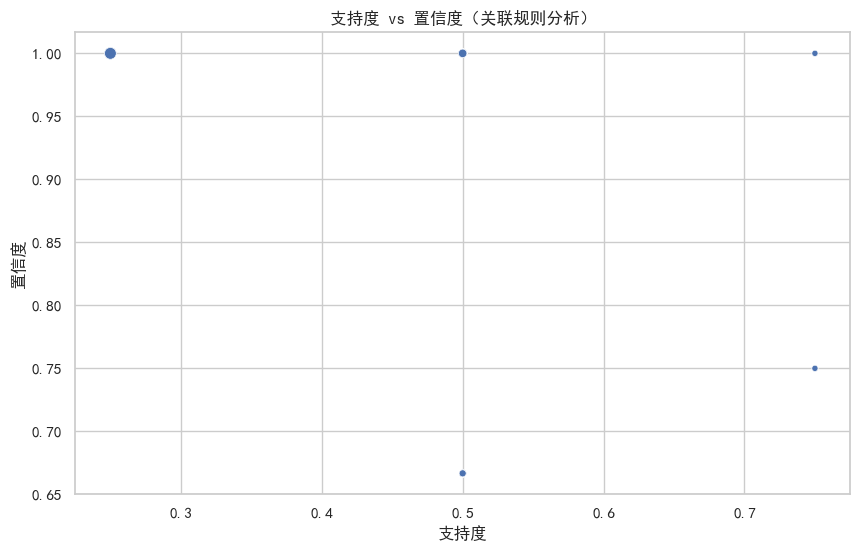

In [15]:
from mlxtend.frequent_patterns import fpgrowth, association_rules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 'data' 是已经加载的畅销书榜单数据

# 1. 限制书籍数量，选择评论最多的前10本书，进一步减少数据规模
top_books = data['书名'].value_counts().head(10).index.tolist()
top_books_data = data[data['书名'].isin(top_books)]

# 2. 创建透视表，转换为布尔类型（直接使用比较运算符）
book_basket = top_books_data.pivot_table(index='排行榜类型', columns='书名', aggfunc='size', fill_value=0)
book_basket = book_basket > 0  # 转换为布尔类型

# 3. 使用 fpgrowth 算法进行关联规则分析
frequent_itemsets = fpgrowth(book_basket, min_support=0.05, use_colnames=True)

# 4. 生成关联规则
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# 5. 输出关联规则结果
print("关联规则结果：")
print(rules[['antecedents', 'consequents', 'support', 'confidence']].head())

# 6. 可视化规则
plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', size='lift', data=rules, legend=False)
plt.title('支持度 vs 置信度（关联规则分析）')
plt.xlabel('支持度')
plt.ylabel('置信度')
plt.show()

4. 畅销图书特征分析
目标：总结畅销书的共同特征，找出它们在类别、作者知名度、出版时间等方面的规律。
方法：
计算各类别、作者、出版年份的畅销书数量，找出它们的分布规律。

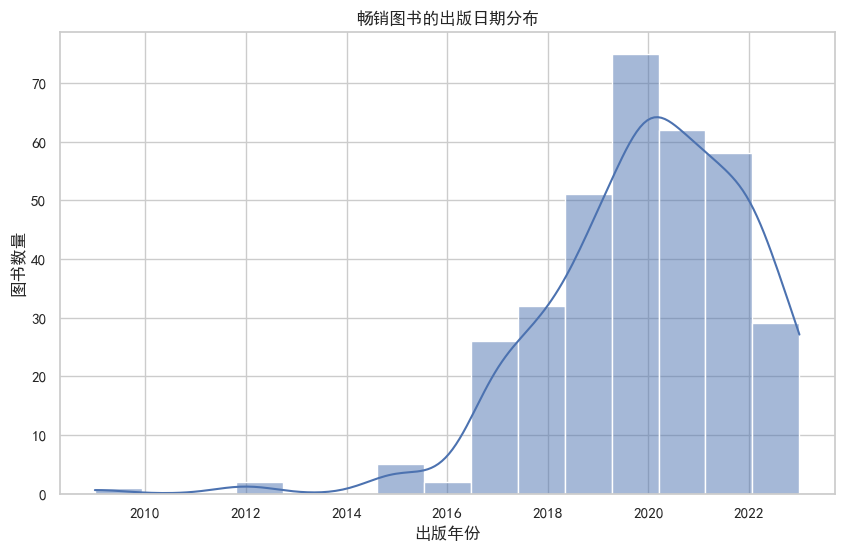

高推荐值书籍的特征分析：
Series([], Name: 书名, dtype: int64)


In [16]:
# 畅销图书特征分析 - 类别、出版日期和推荐值的分布
plt.figure(figsize=(10, 6))
sns.histplot(data['出版日期'].dt.year.dropna(), bins=15, kde=True)
plt.title('畅销图书的出版日期分布')
plt.xlabel('出版年份')
plt.ylabel('图书数量')
plt.show()

# 根据推荐值进行分析，找出推荐值高的图书的共同特征
high_recommend_books = data[data['推荐值'] > 80]  # 假设推荐值高于80%为高推荐书籍
print("高推荐值书籍的特征分析：")
print(high_recommend_books.groupby('出版社')['书名'].count().sort_values(ascending=False).head(10))